In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps

In [26]:
def replace_outliers_with_median(df):
    df_clean = df.copy()  # Copia il DataFrame originale per non modificarlo direttamente

    for col in df.columns:
        if col != 'quality':
            q1 = df[col].quantile(0.25)  # Calcola il primo quartile
            q3 = df[col].quantile(0.75)  # Calcola il terzo quartile
            iqr = q3 - q1  # Calcola l'interquartile range (IQR)

            # Calcola i limiti per gli outlier
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            # Sostituisci gli outlier con la mediana
            median = df_clean[col].median()
            df_clean[col] = df_clean[col].apply(lambda x: median if x < lower_bound or x > upper_bound else x)

    return df_clean


In [27]:
def remove_outliers(df):

    df_clean = df.copy()  # Copia il DataFrame originale per non modificarlo direttamente

    for col in df.columns:
        if col != 'quality':
            q1 = df[col].quantile(0.25)  # Calcola il primo quartile
            q3 = df[col].quantile(0.75)  # Calcola il terzo quartile
            iqr = q3 - q1  # Calcola l'interquartile range (IQR)

            # Calcola i limiti per gli outlier
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            # Rimuovi gli outlier
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    return df_clean

In [28]:
def new_quality_value(df):
    
    new_df = df.copy()
    # Mappa i valori della colonna 'quality' 
    quality_mapping = {3: 0, 4: 0, 5: 1, 6: 1, 7: 2, 8: 2}
    new_df['quality'] = new_df['quality'].replace(quality_mapping)
    
    return new_df


In [64]:
def classificator (dataset, classifier, testsize):
    accuracy_dict={}
    x_data=dataset.drop(columns=[classifier])
    y_data=dataset.loc[:,classifier]
    x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=testsize,random_state=10)

    accuracy_dict['Size']= dataset.shape[0]
    # RandomForestClassifier 
    rf_model = RandomForestClassifier(n_estimators=1000, random_state=20)
    rf_model.fit(x_train, y_train)

    y_pred = rf_model.predict(x_test)

    # Valutazione delle prestazioni del modello
    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del modello RandomForestClassifier: %.3f" %accuracy)
    accuracy_dict['RandomForest']=round(accuracy,3)

    # Classificatore SVM con solo relevant feature
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

    svm_classifier.fit(x_train, y_train)
    y_pred = svm_classifier.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del classificatore SVM: %.3f" %accuracy)
    accuracy_dict['SVM']=round(accuracy,3)

    # Crea il modello di regressione logistica con solo relevant
    logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000, random_state=42)

    logistic_regression.fit(x_train, y_train)
    y_pred = logistic_regression.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del modello di regressione logistica: %.3f" %accuracy)
    accuracy_dict['Regression']=accuracy

    # DecisionTreeClassifier con tutte le feature
    tree_classifier = DecisionTreeClassifier(random_state=42)

    tree_classifier.fit(x_train, y_train)
    y_pred = tree_classifier.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del classificatore ad albero decisionale: %.3f" %accuracy)
    accuracy_dict['Tree']=round(accuracy,3)


    # Classificatore naive bayes con relevant feature
    naive_bayes_classifier = GaussianNB()
    naive_bayes_classifier.fit(x_train, y_train)

    y_pred = naive_bayes_classifier.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del classificatore Naive Bayes: %.3f" %accuracy)
    accuracy_dict['Bayes']=round(accuracy,3)

    return accuracy_dict


In [30]:
def classification_evo(dataframe, testsize):

    data=dataframe.copy()

    data_clean=replace_outliers_with_median(data)
    data_clean_remove=remove_outliers(data)

    relevant=dataframe.drop(columns=['fixed_acidity','residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH'])
    relevant_clean=replace_outliers_with_median(relevant)
    relevant_clean_remove=remove_outliers(relevant)

    result=pd.DataFrame()

    result['Data'+'_'+str(testsize)]=classificator(data,'quality',testsize)

    result['Relevant'+'_'+str(testsize)]=classificator(relevant,'quality', testsize)

    result['Data_Clean'+'_'+str(testsize)]=classificator(data_clean,'quality', testsize)

    result['Relevant_Clean'+'_'+str(testsize)]=classificator(relevant_clean, 'quality', testsize)

    result['Data_Remove'+'_'+str(testsize)]=classificator(data_clean_remove,'quality', testsize)

    result['Relevant_Remove'+'_'+str(testsize)]=classificator(relevant_clean_remove, 'quality', testsize)

    return result


In [68]:
def plot_result_evo(res):
    num=res.iloc[0]
    result=res.drop(index= ['Size'])
    num_cols = len(result.columns)
    num_rows = (num_cols + 1) // 2 

    # Creazione del grafico a barre
    fig, axs = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))

    # Itera sul DataFrame e crea i subplot
    for i, (col_name, col_data) in enumerate(result.items()):
        row = i // 2
        col = i % 2
        keys = result.index
        values = col_data
        colors = plt.cm.RdBu(np.array(values) / max(values))
        
        for j, v in enumerate(values):
            axs[row, col].text(j, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
        
        axs[row, col].bar(keys, values, color=colors)
        axs[row, col].set_ylabel('Valori')
        axs[row, col].set_title('Dataset name='+col_name+'   Dataset size='+str(num.iloc[i]))
        axs[row, col].set_xticks(keys)
        axs[row, col].set_xticklabels(keys, rotation=45, ha='right')
        axs[row, col].set_ylim(0, max(values) * 1.2)

    # Rimuovi i subplot non utilizzati
    for i in range(num_cols, num_rows*2):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()
    plt.show()


In [32]:
def trova_max(df):
    # Trova il massimo in ogni riga
    max_values = df.max(axis=1)

    # Trova l'indice del massimo in ogni riga
    max_indices = df.idxmax(axis=1)

    max_df = pd.DataFrame({'Max_Value': max_values, 'Index': max_indices})
    return max_df

In [149]:
def plot_bar_chart_df_evo(df):
  
    keys = df.index.tolist()  
    values = df.iloc[:, 0].tolist()  
    x_labels = [f"{key}: {df.iloc[i, 1]}" for i, key in enumerate(keys)]  
   

    colors = plt.cm.RdBu(np.array(values) / max(values)) 

    # Aggiungi valori sulle barplot
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
    
    plt.bar(keys, values, color=colors)
    plt.xlabel('Algoritmi')
    plt.ylabel('Performance')
    plt.xticks(range(len(keys)), x_labels, rotation=45, ha='right')
    plt.ylim(0, max(values) * 1.2)
    plt.show()



In [33]:
wine_dataframe = pd.read_csv('restore_winedata.csv')
result={}
data=wine_dataframe.copy()
data.shape

(1599, 12)

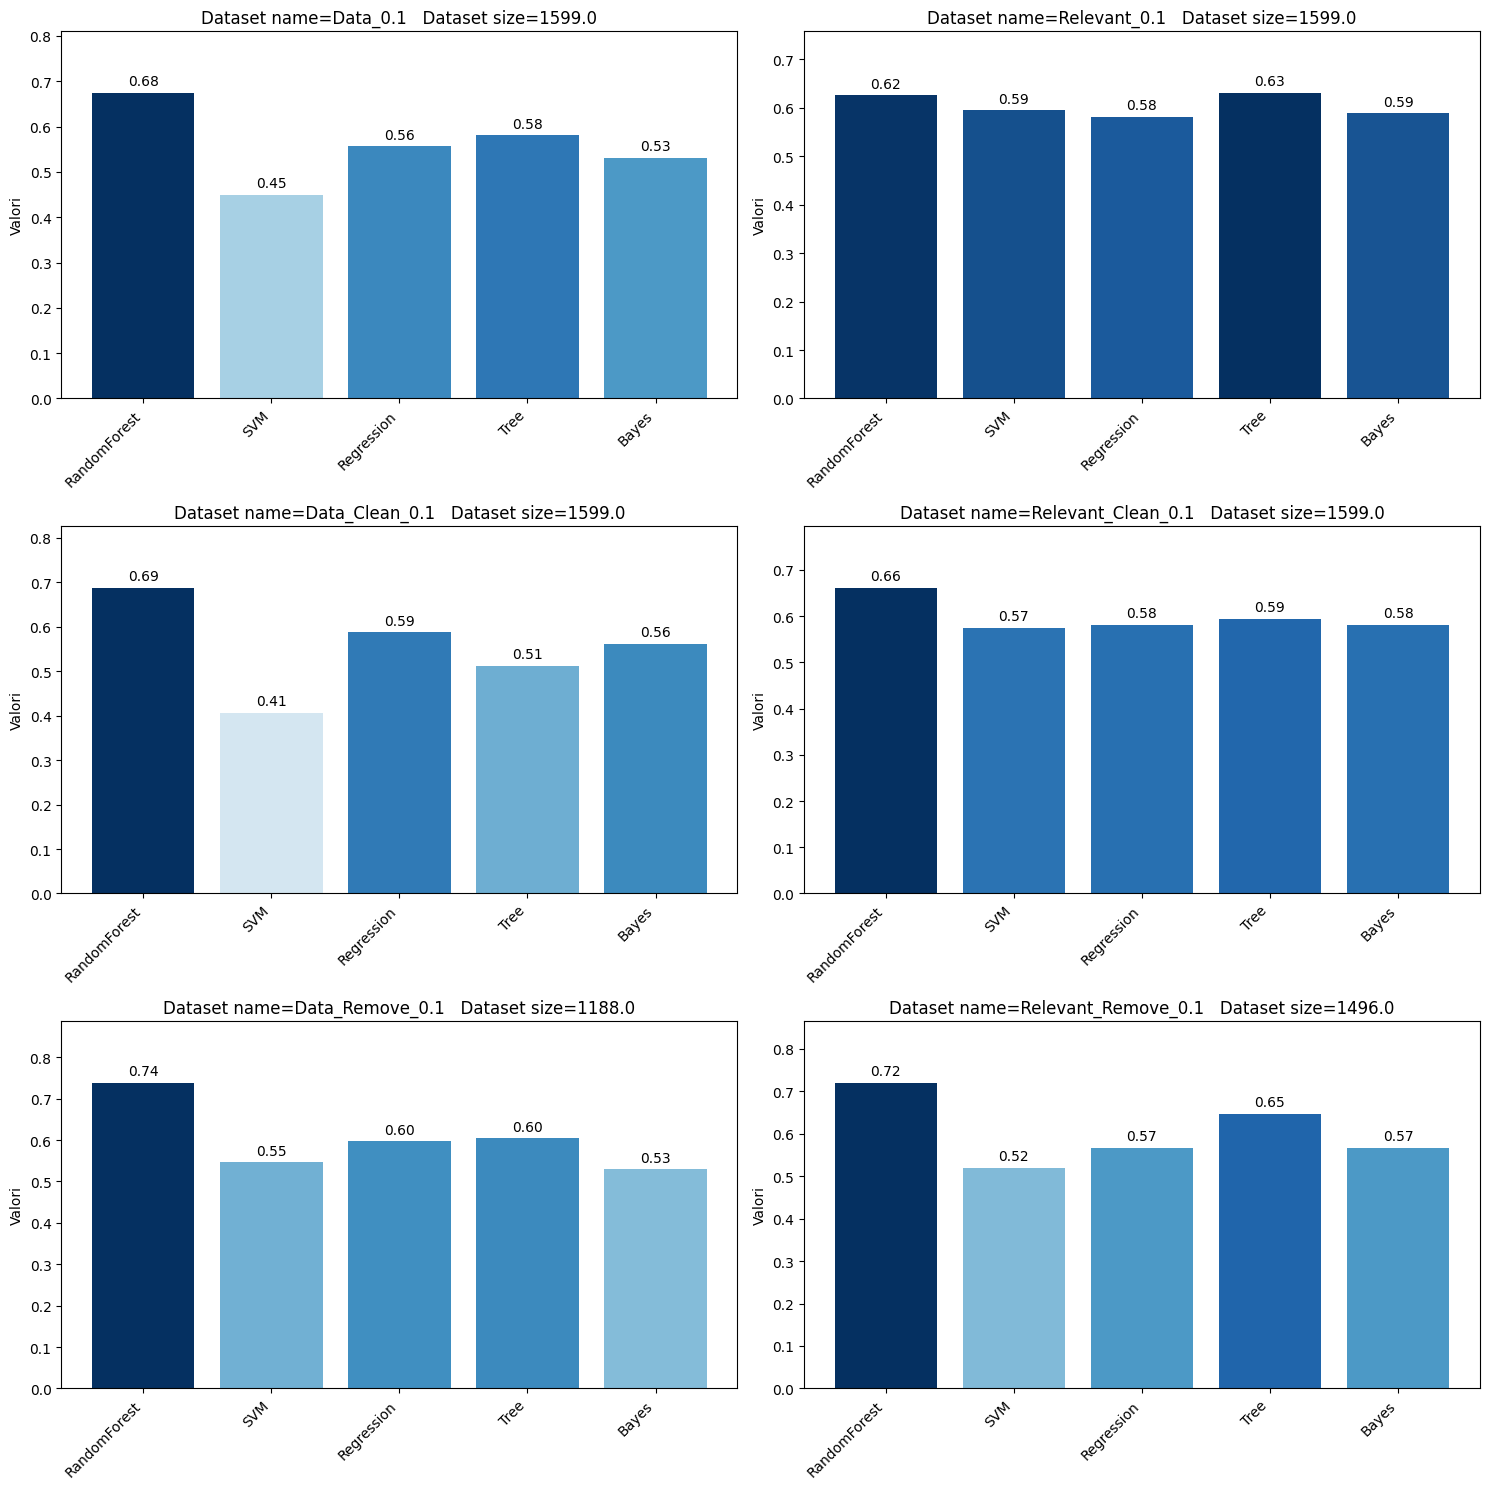

In [69]:
result['r_10']=classification_evo(data,0.10)
plot_result_evo(result['r_10'])

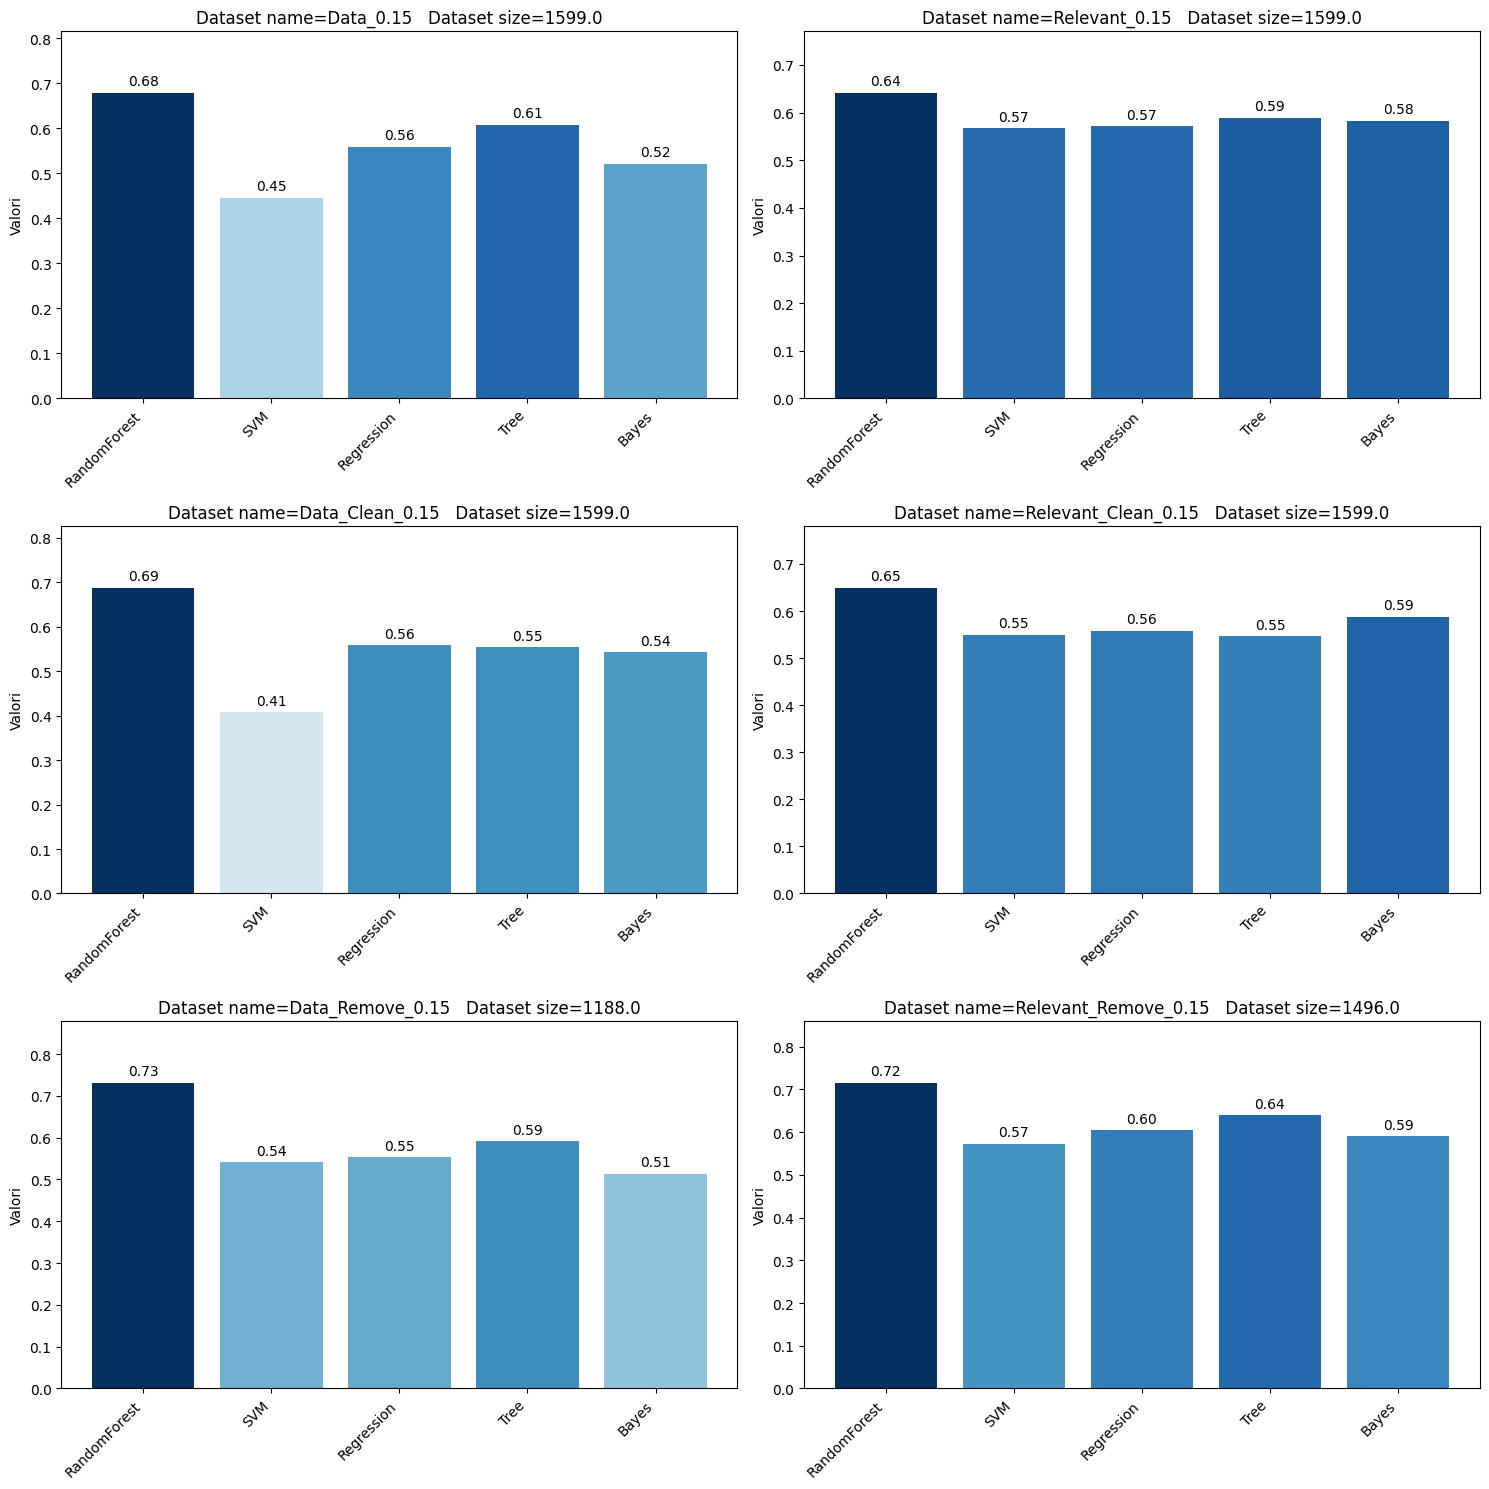

In [71]:
result['r_15']=classification_evo(data,0.15)
plot_result_evo(result['r_15'])

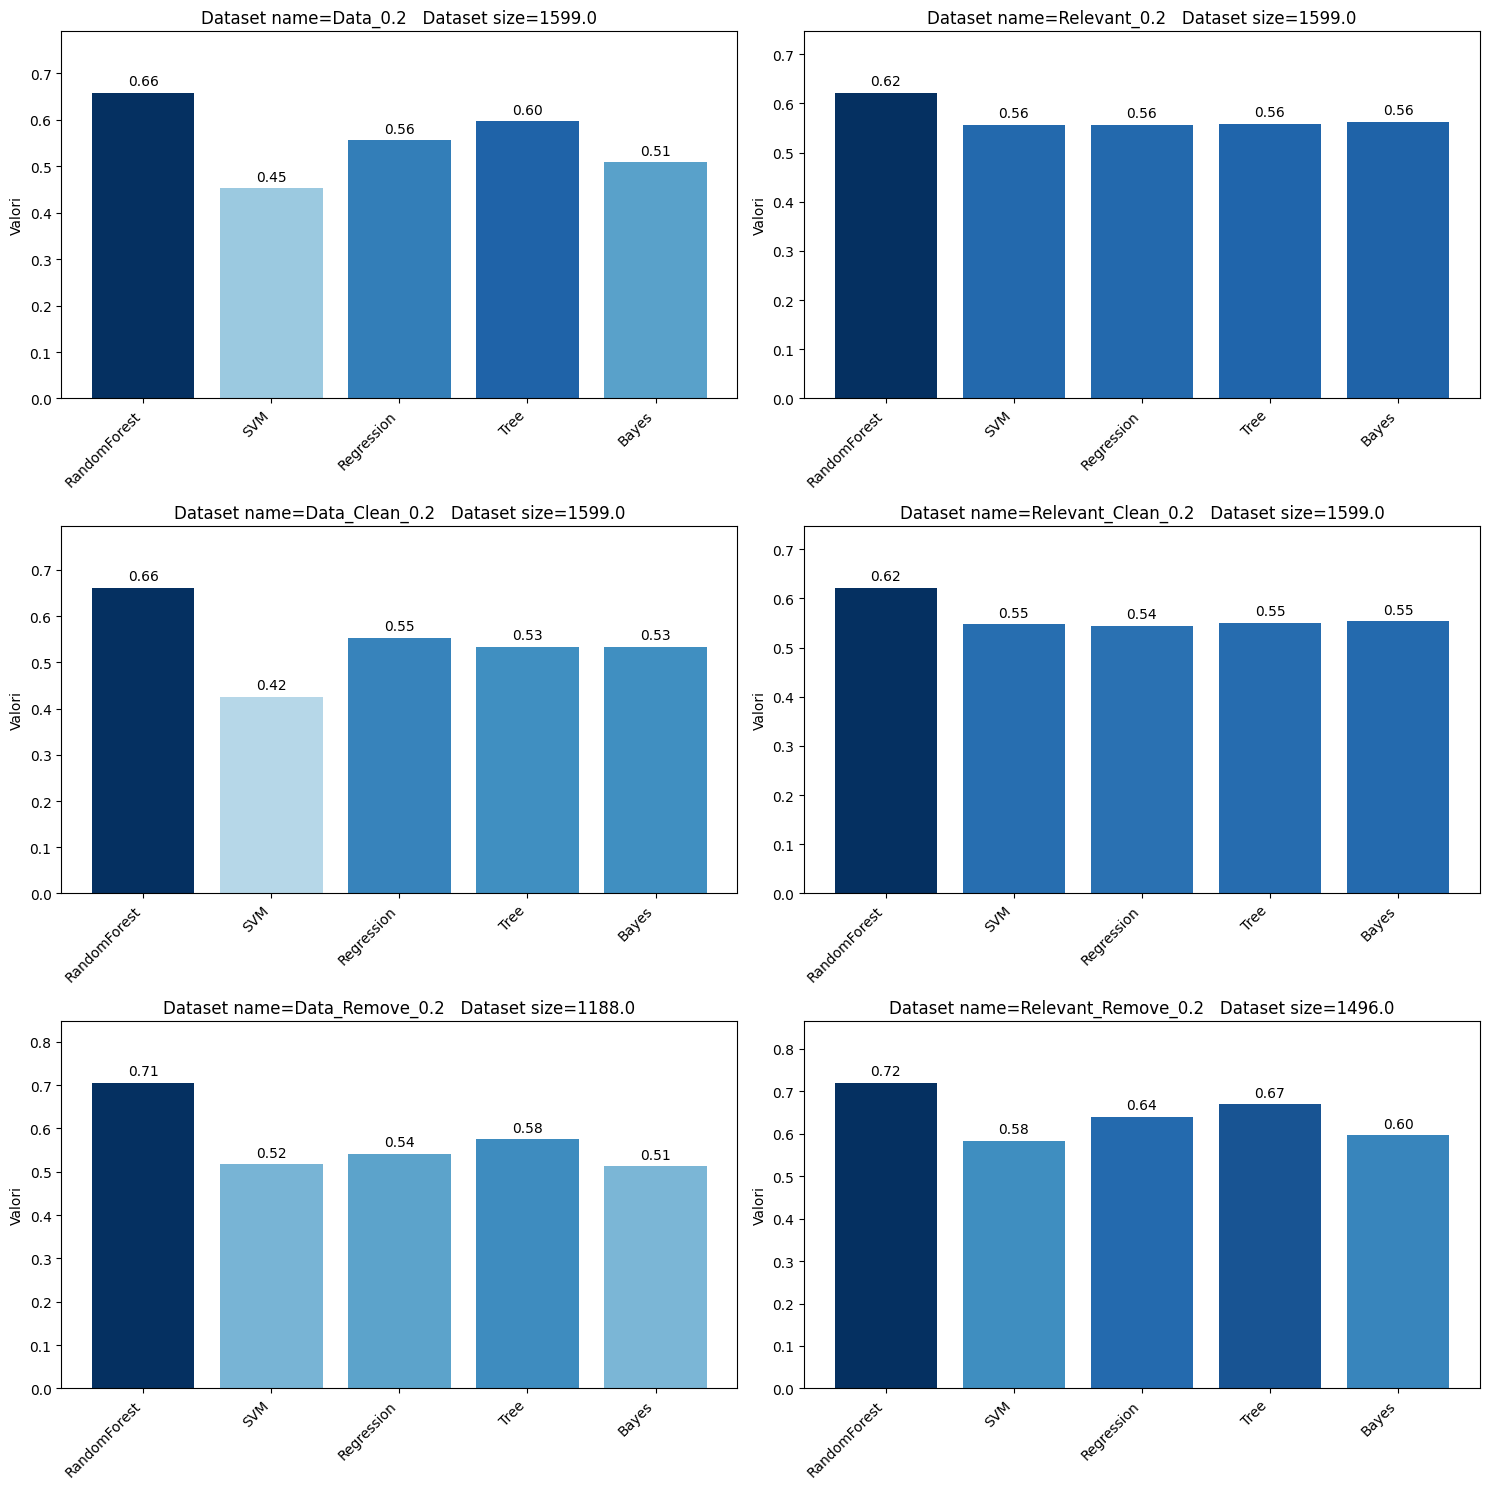

In [86]:
result['r_20']=classification_evo(data,0.20)
plot_result_evo(result['r_20'])

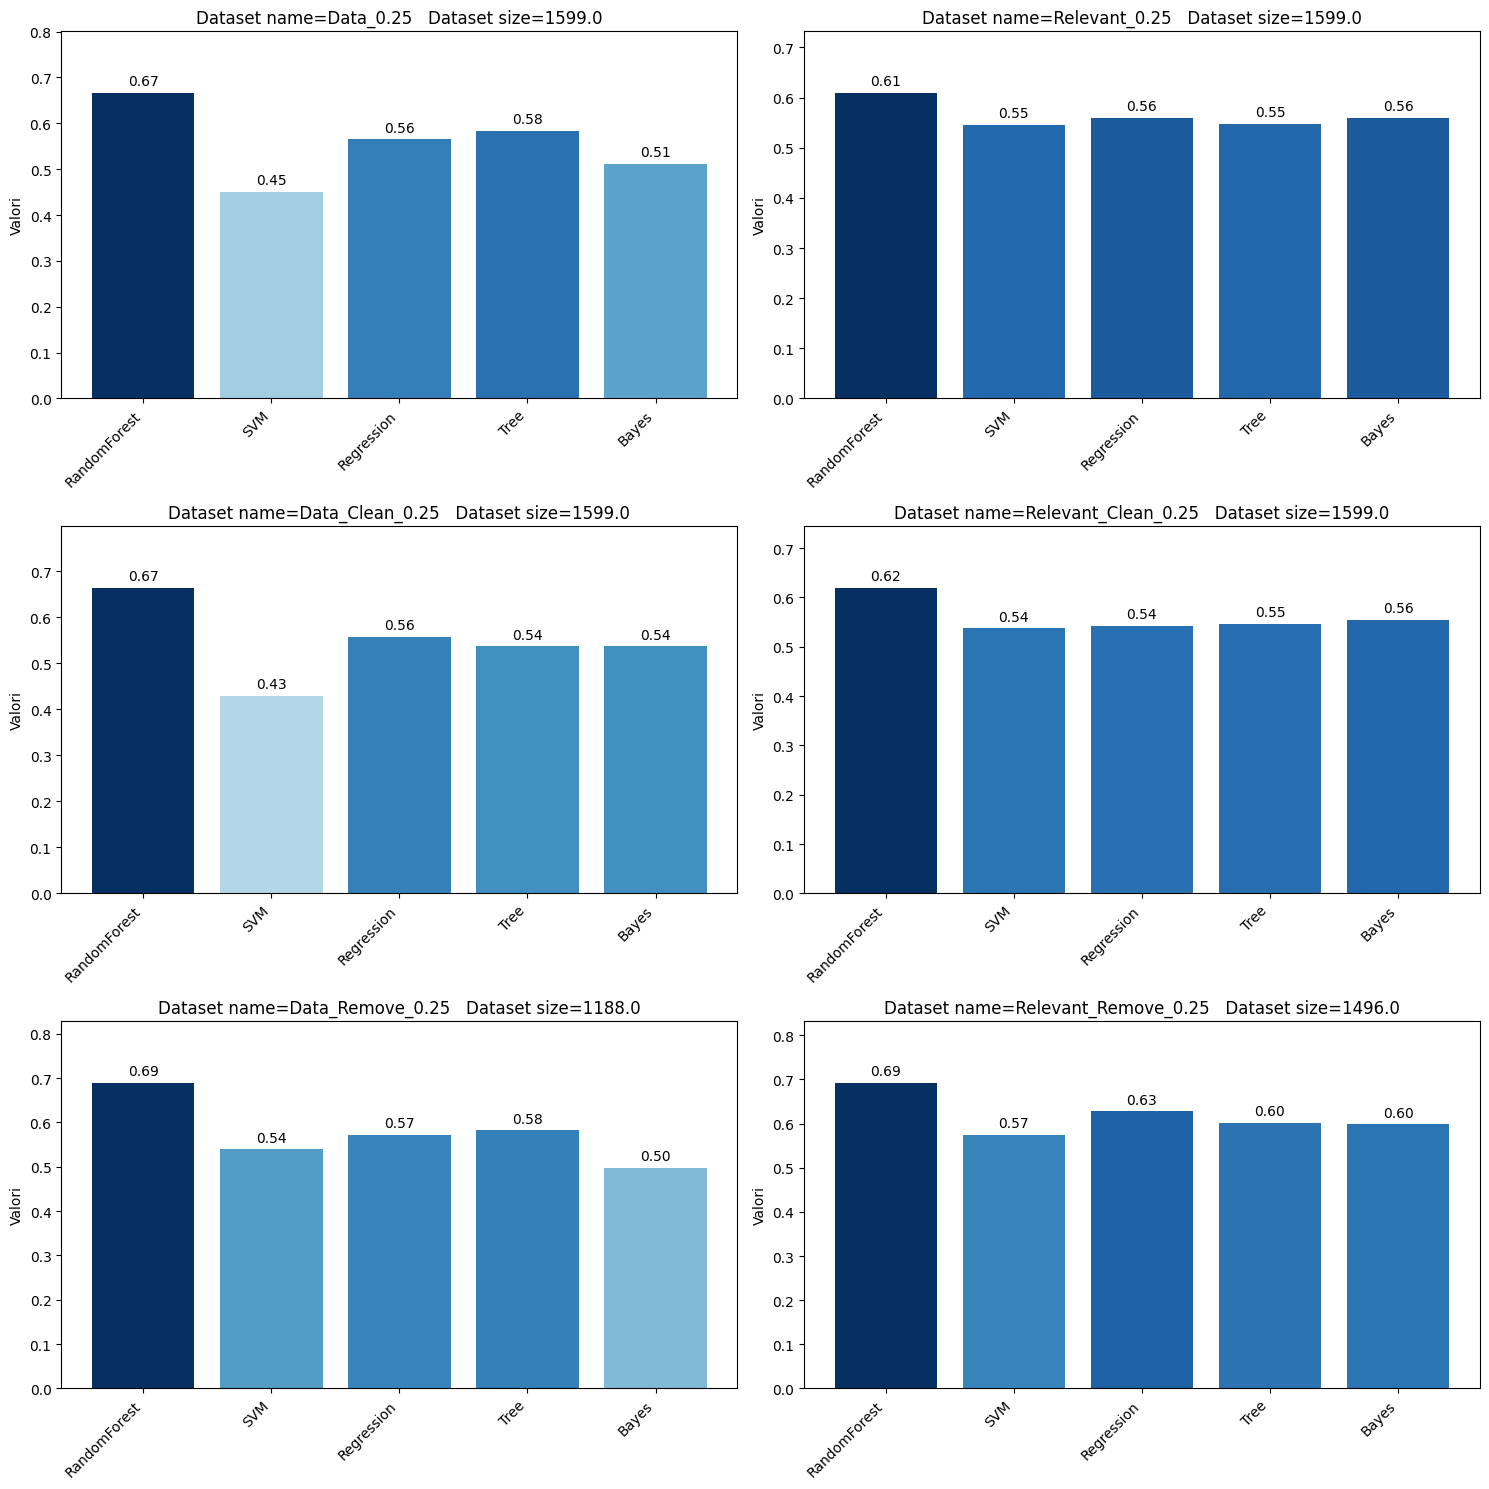

In [87]:
result['r_25']=classification_evo(data,0.25)
plot_result_evo(result['r_25'])

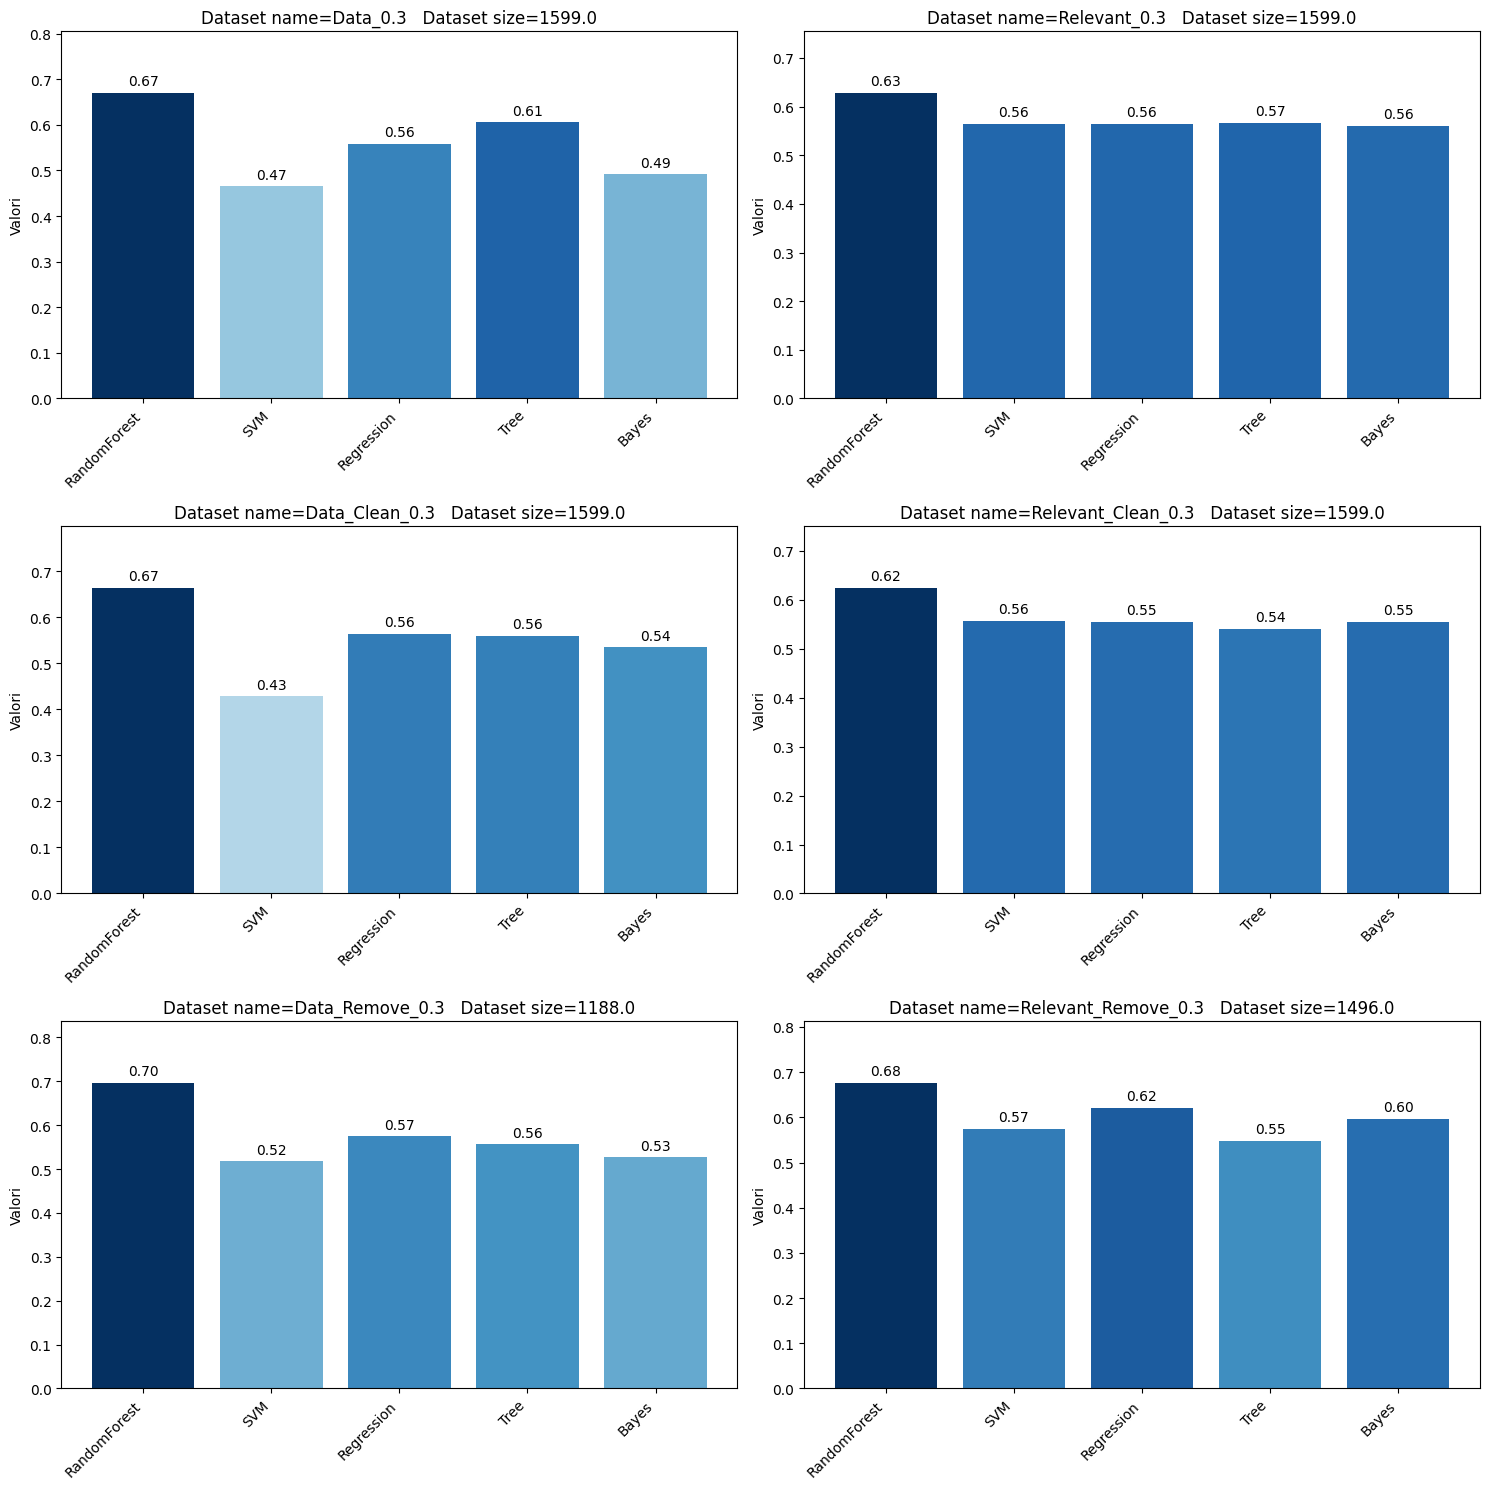

In [88]:
result['r_30']=classification_evo(data,0.30)
plot_result_evo(result['r_30'])

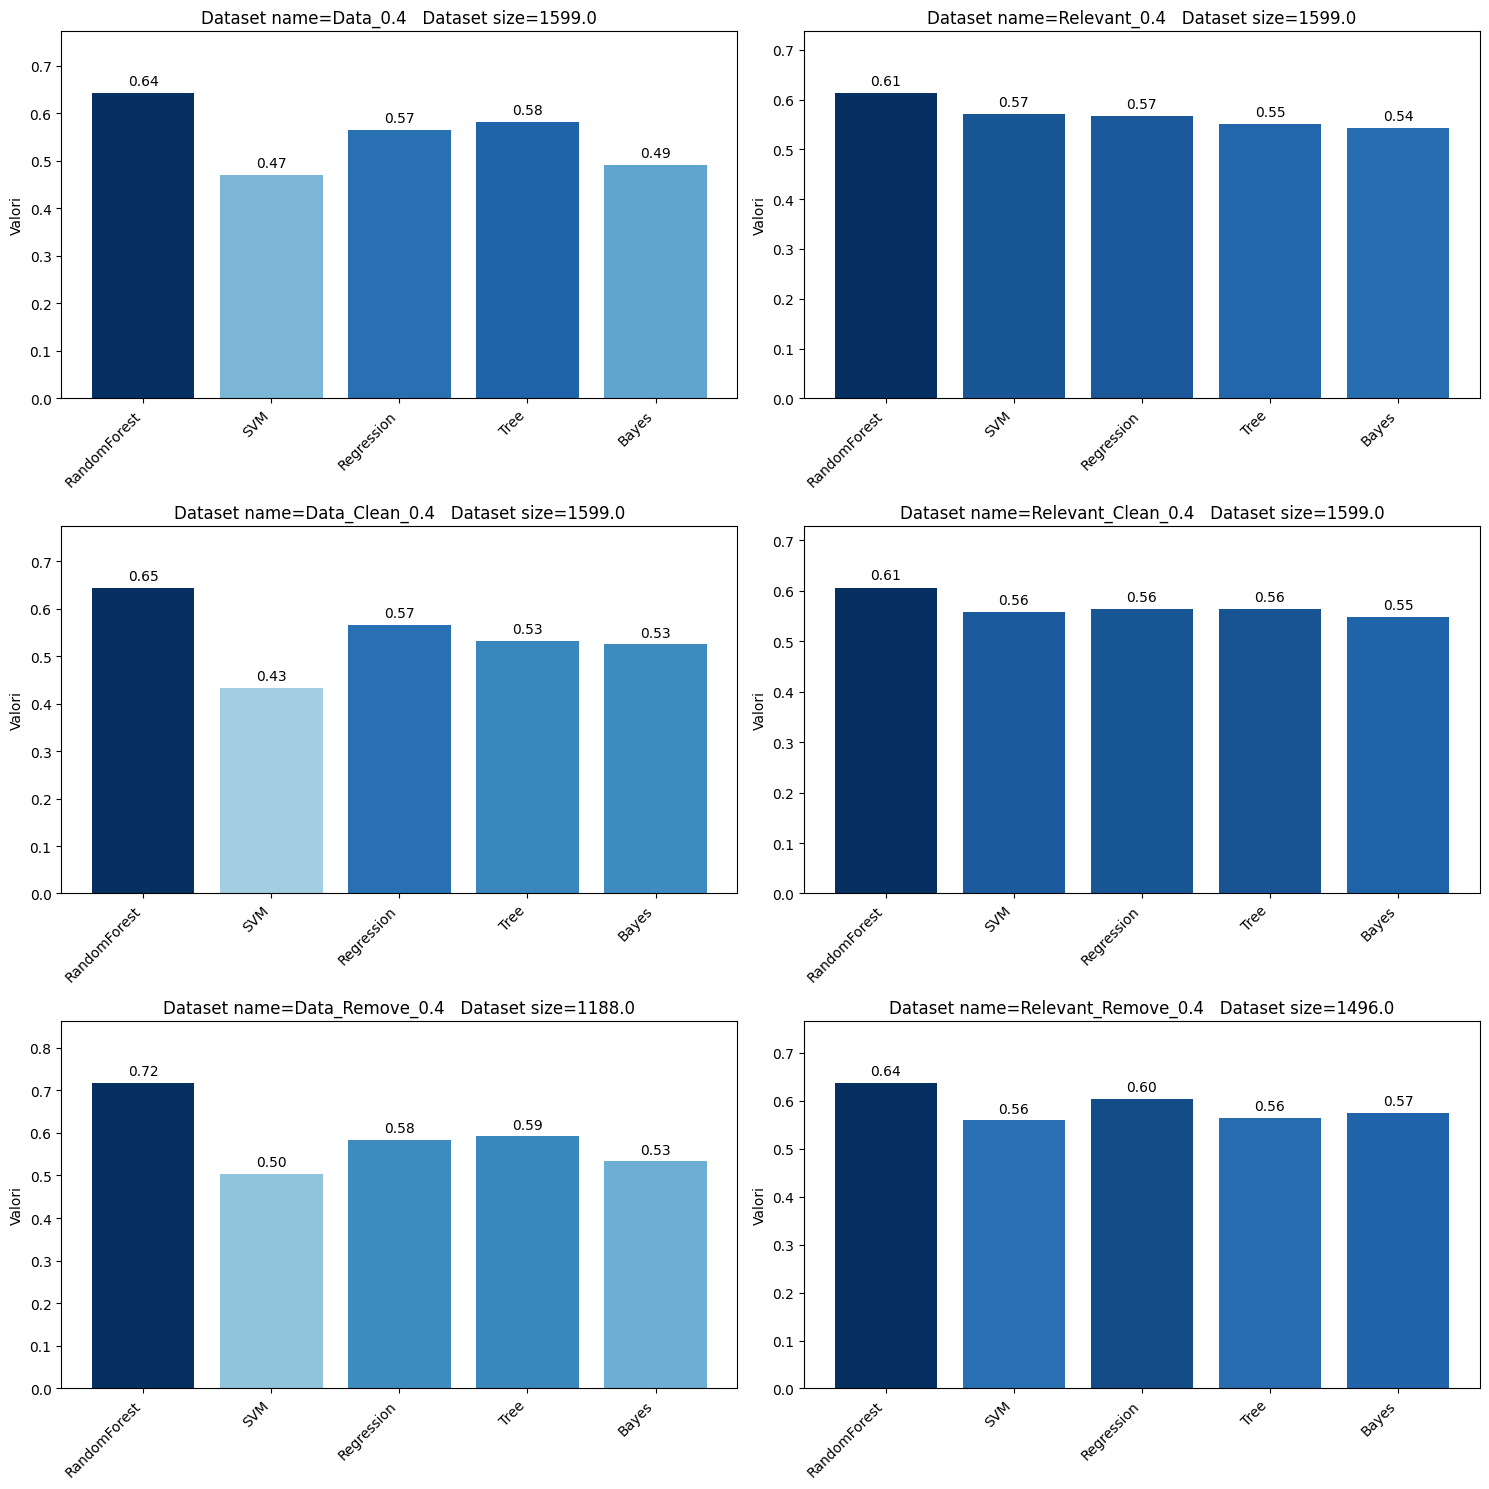

In [89]:
result['r_40']=classification_evo(data,0.40)
plot_result_evo(result['r_40'])

In [90]:
merged_df = pd.concat([result['r_10'], result['r_15'], result['r_20'],
                      result['r_25'], result['r_30'], result['r_40']],
                      axis=1)

In [91]:
d_1599 = merged_df.loc[:, (merged_df == 1599).any()]
df_1599=d_1599.drop(index=['Size'])
df_1599

,Data_0.1,Relevant_0.1,Data_Clean_0.1,Relevant_Clean_0.1,Data_0.15,Relevant_0.15,Data_Clean_0.15,Relevant_Clean_0.15,Data_0.2,Relevant_0.2,...,Data_Clean_0.25,Relevant_Clean_0.25,Data_0.3,Relevant_0.3,Data_Clean_0.3,Relevant_Clean_0.3,Data_0.4,Relevant_0.4,Data_Clean_0.4,Relevant_Clean_0.4
RandomForest,0.67500,0.62500,0.6880,0.66200,0.679000,0.642000,0.688000,0.650000,0.65900,0.62200,...,0.6650,0.6200,0.671000,0.629000,0.665000,0.625000,0.644000,0.614000,0.645000,0.6060
SVM,0.45000,0.59400,0.4060,0.57500,0.446000,0.567000,0.408000,0.550000,0.45300,0.55600,...,0.4300,0.5370,0.465000,0.565000,0.429000,0.556000,0.470000,0.570000,0.434000,0.5580
Regression,0.55625,0.58125,0.5875,0.58125,0.558333,0.570833,0.558333,0.558333,0.55625,0.55625,...,0.5575,0.5425,0.558333,0.564583,0.564583,0.554167,0.565625,0.567187,0.565625,0.5625
Tree,0.58100,0.63100,0.5120,0.59400,0.608000,0.588000,0.554000,0.546000,0.59700,0.55900,...,0.5370,0.5470,0.606000,0.567000,0.560000,0.540000,0.583000,0.550000,0.533000,0.5640
Bayes,0.53100,0.58800,0.5620,0.58100,0.521000,0.583000,0.542000,0.588000,0.50900,0.56200,...,0.5370,0.5550,0.492000,0.560000,0.535000,0.554000,0.491000,0.542000,0.525000,0.5470


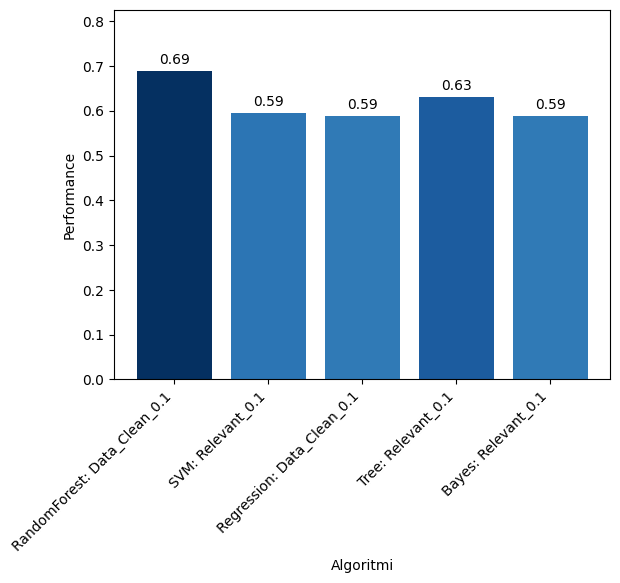

In [156]:
max_1599=trova_max(df_1599)
plot_bar_chart_df_evo(max_1599)

In [93]:
d_1496 = merged_df.loc[:, (merged_df == 1496).any()]
df_1496=d_1496.drop(index=['Size'])
df_1496

,Relevant_Remove_0.1,Relevant_Remove_0.15,Relevant_Remove_0.2,Relevant_Remove_0.25,Relevant_Remove_0.3,Relevant_Remove_0.4
RandomForest,0.720000,0.716000,0.720,0.693000,0.677000,0.638000
SVM,0.520000,0.573000,0.583,0.575000,0.575000,0.559000
Regression,0.566667,0.604444,0.640,0.628342,0.621381,0.604341
Tree,0.647000,0.640000,0.670,0.602000,0.548000,0.564000
Bayes,0.567000,0.591000,0.597,0.599000,0.597000,0.574000


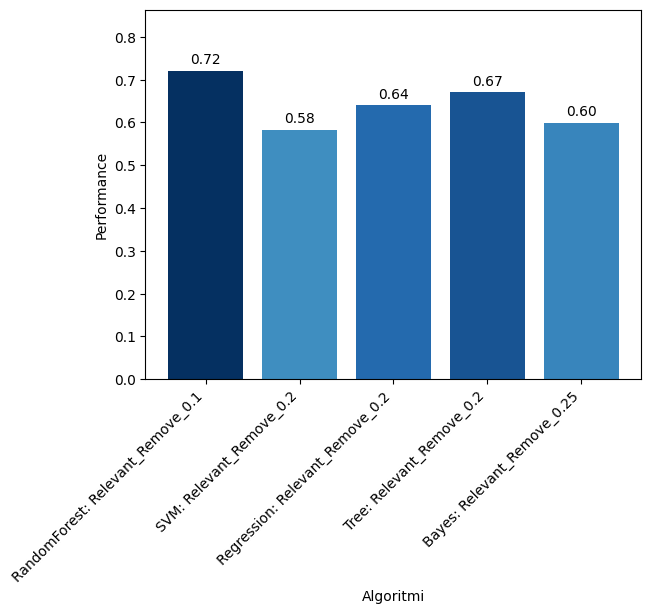

In [153]:
max_1496=trova_max(df_1496)
plot_bar_chart_df_evo(max_1496)

In [154]:
d_1188 = merged_df.loc[:, (merged_df == 1188).any()]
df_1188=d_1188.drop(index=['Size'])
df_1188

,Data_Remove_0.1,Data_Remove_0.15,Data_Remove_0.2,Data_Remove_0.25,Data_Remove_0.3,Data_Remove_0.4
RandomForest,0.739000,0.732000,0.706000,0.690000,0.69700,0.718000
SVM,0.546000,0.542000,0.517000,0.539000,0.51800,0.504000
Regression,0.596639,0.553073,0.542017,0.572391,0.57423,0.584034
Tree,0.605000,0.592000,0.576000,0.582000,0.55700,0.592000
Bayes,0.529000,0.514000,0.513000,0.498000,0.52700,0.534000


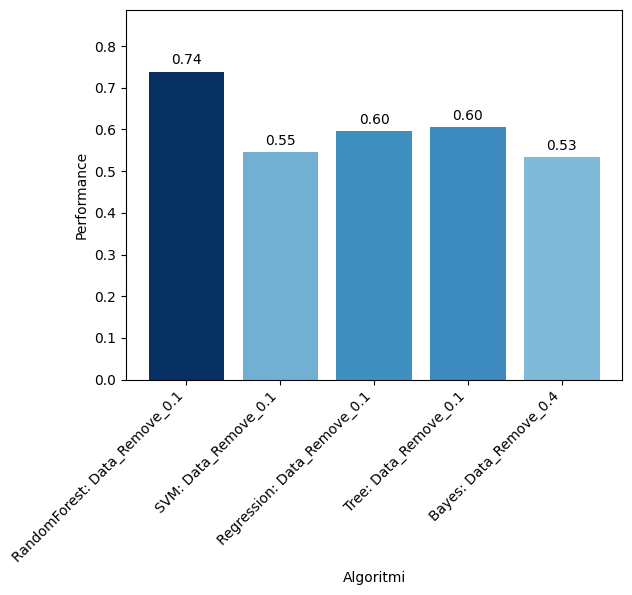

In [155]:
max_1188=trova_max(df_1188)
plot_bar_chart_df_evo(max_1188)

## Reduce of quality Feature

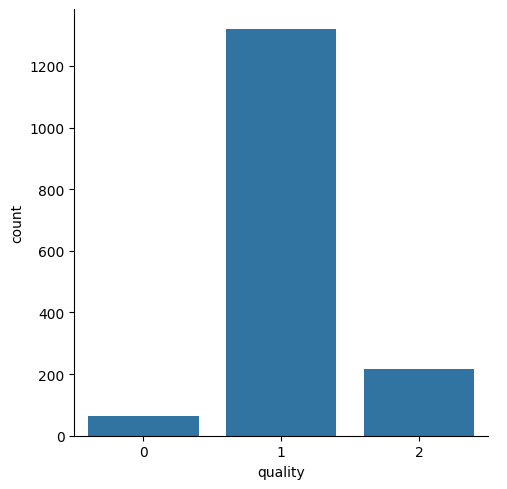

In [97]:
new_data=new_quality_value(data)
new_result={}
sns.catplot(x='quality',data=new_data, kind='count')  #counting and rappresenting different label
plt.show()

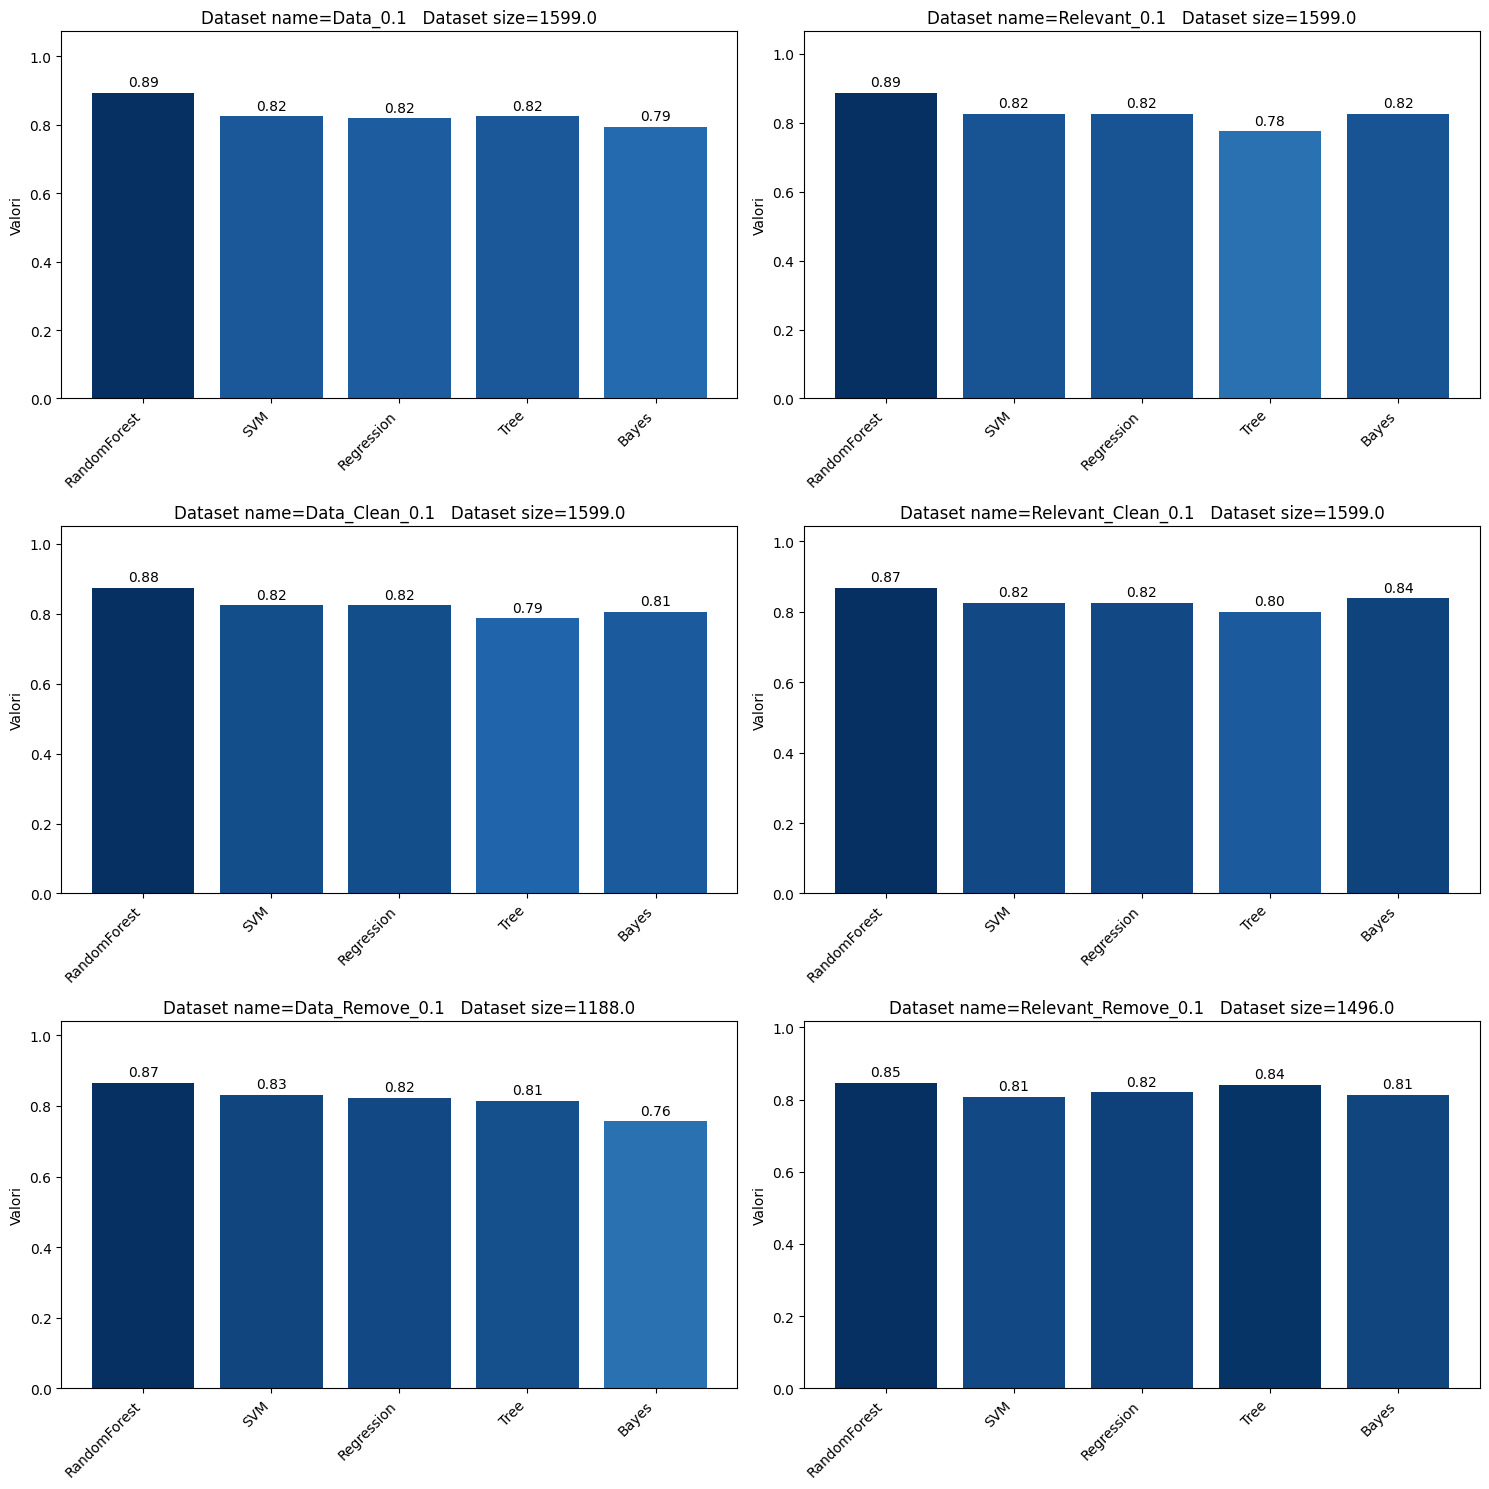

In [98]:
new_result['n_10']=classification_evo(new_data,0.10)
plot_result_evo(new_result['n_10'])

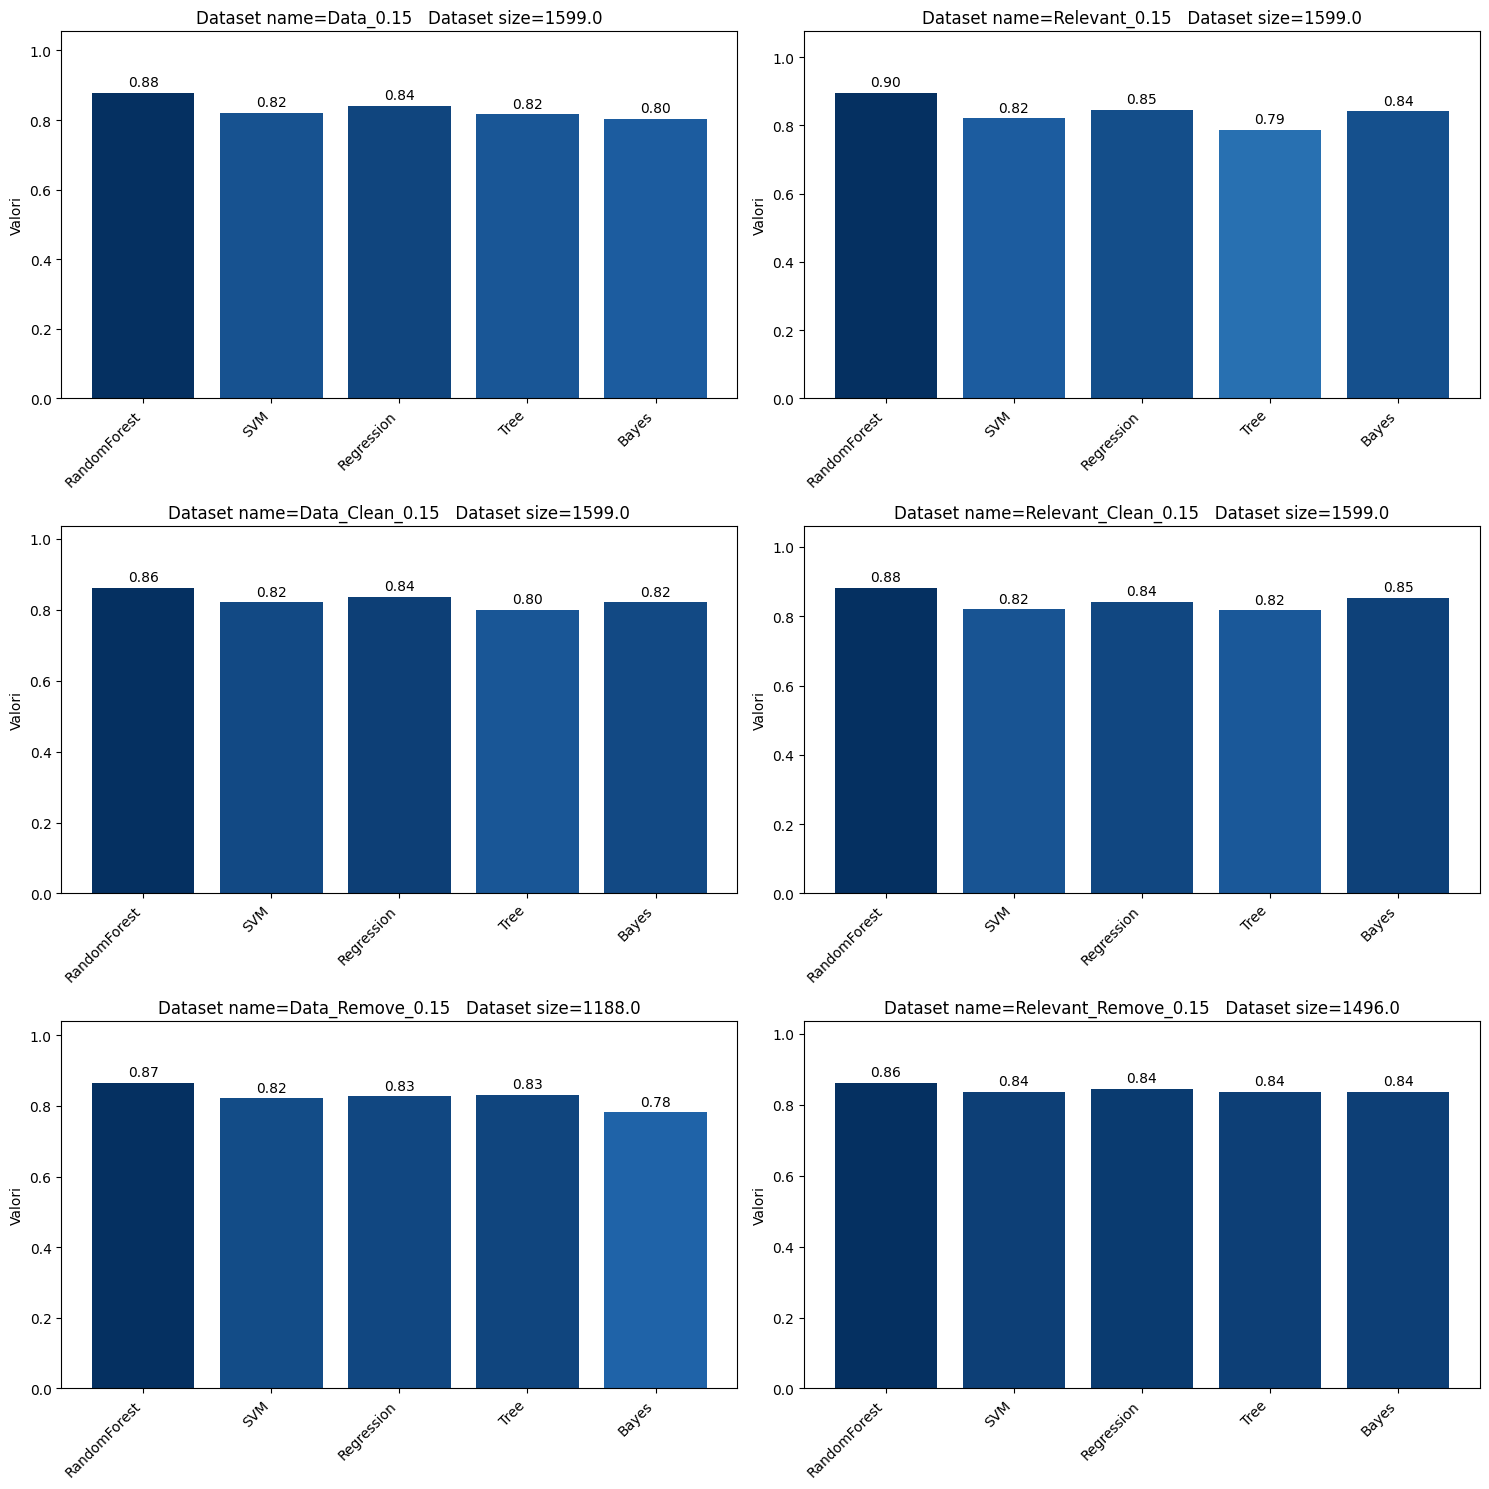

In [99]:
new_result['n_15']=classification_evo(new_data,0.15)
plot_result_evo(new_result['n_15'])

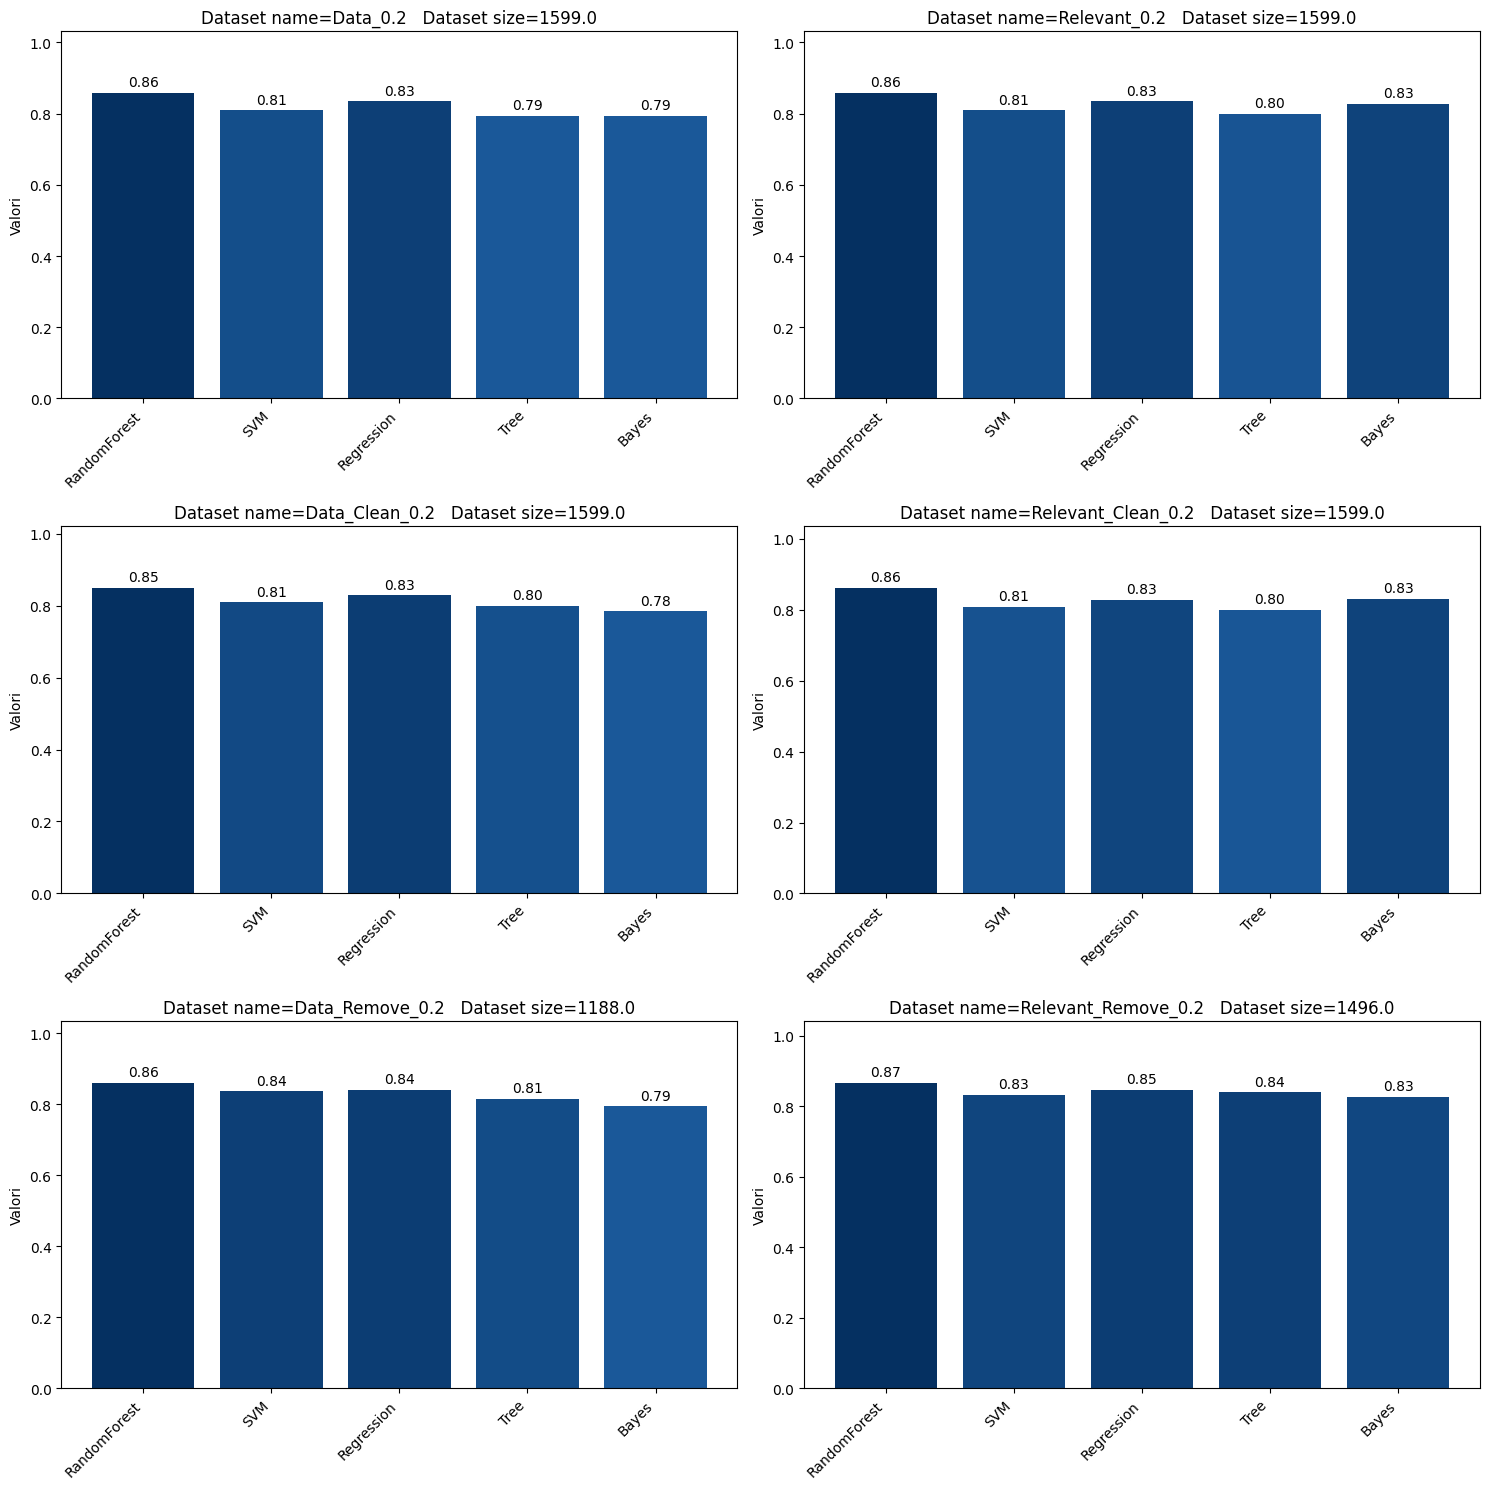

In [100]:
new_result['n_20']=classification_evo(new_data,0.20)
plot_result_evo(new_result['n_20'])

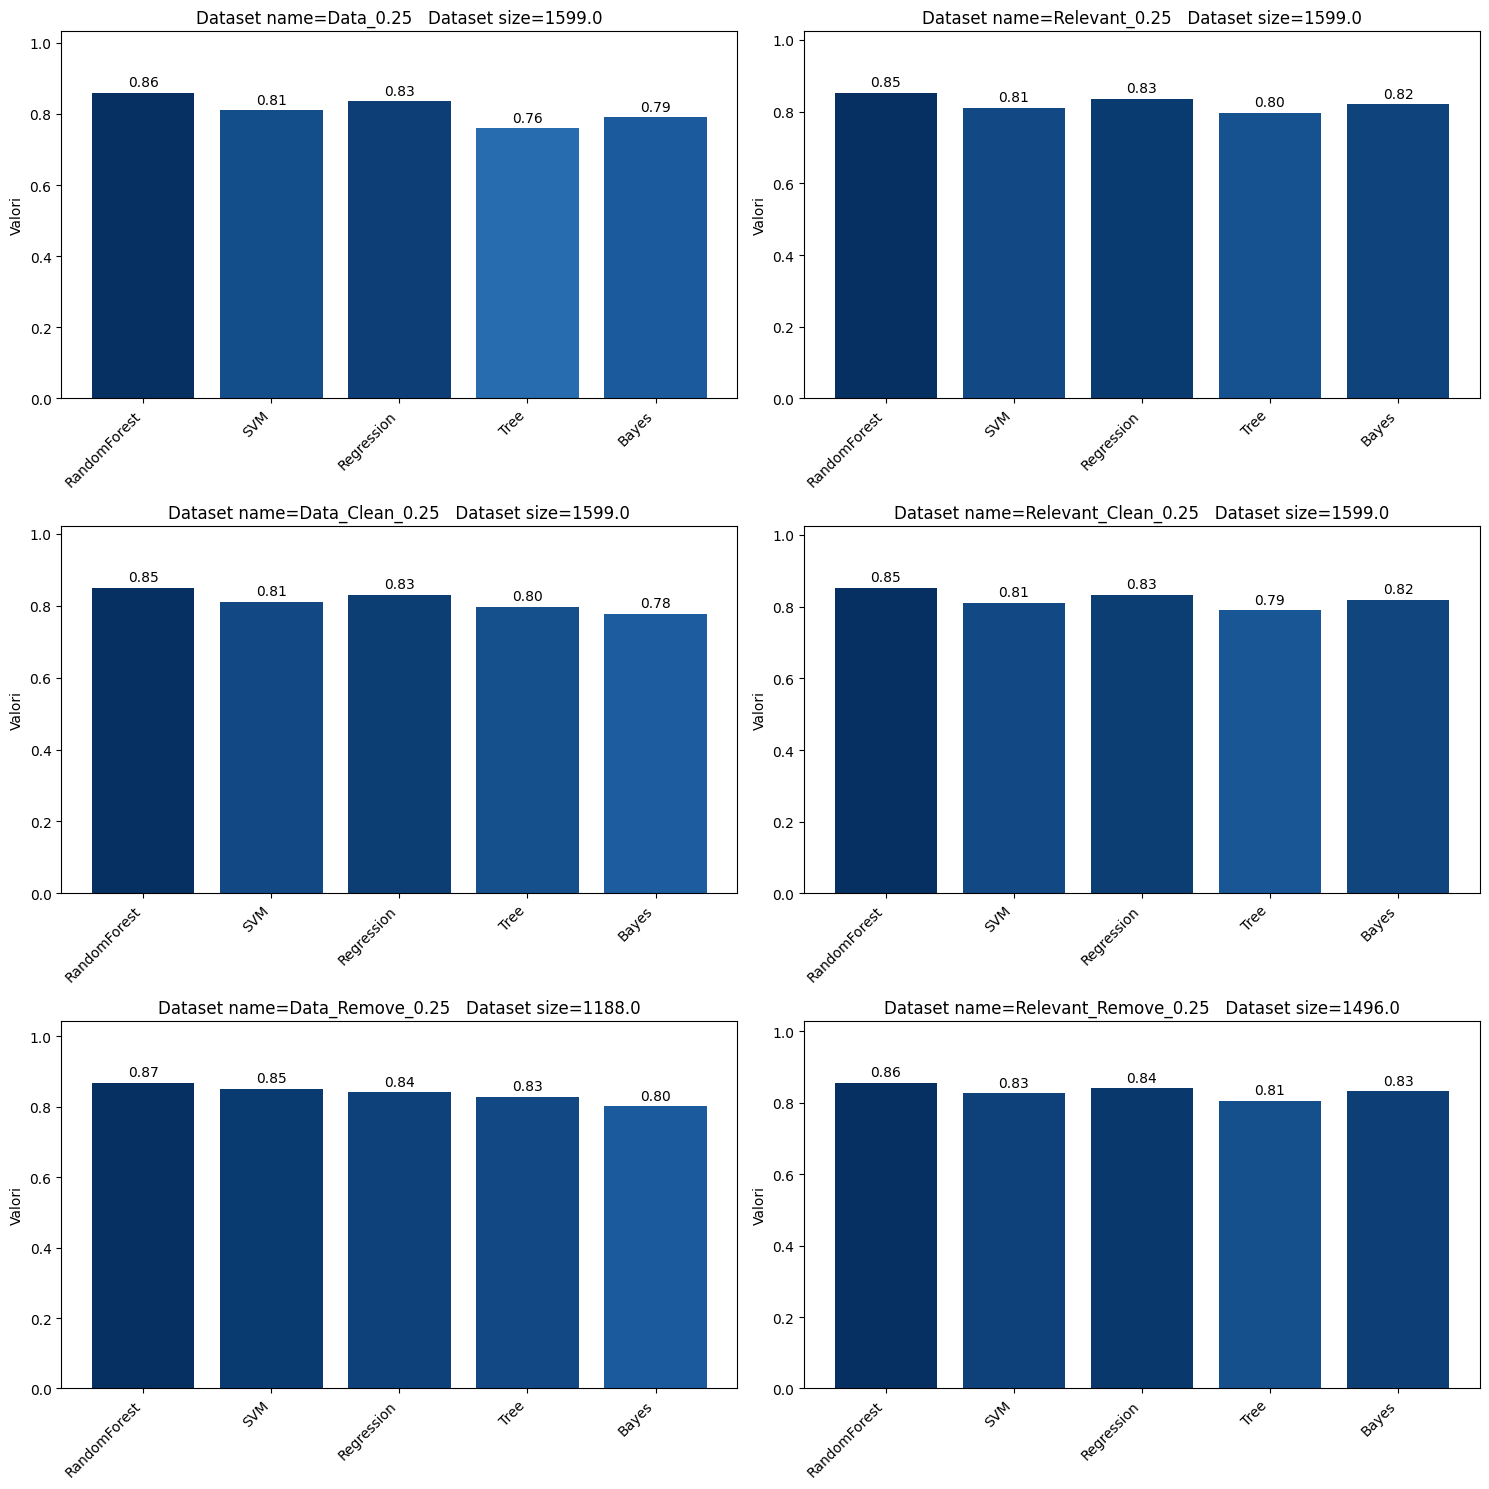

In [101]:
new_result['n_25']=classification_evo(new_data,0.25)
plot_result_evo(new_result['n_25'])

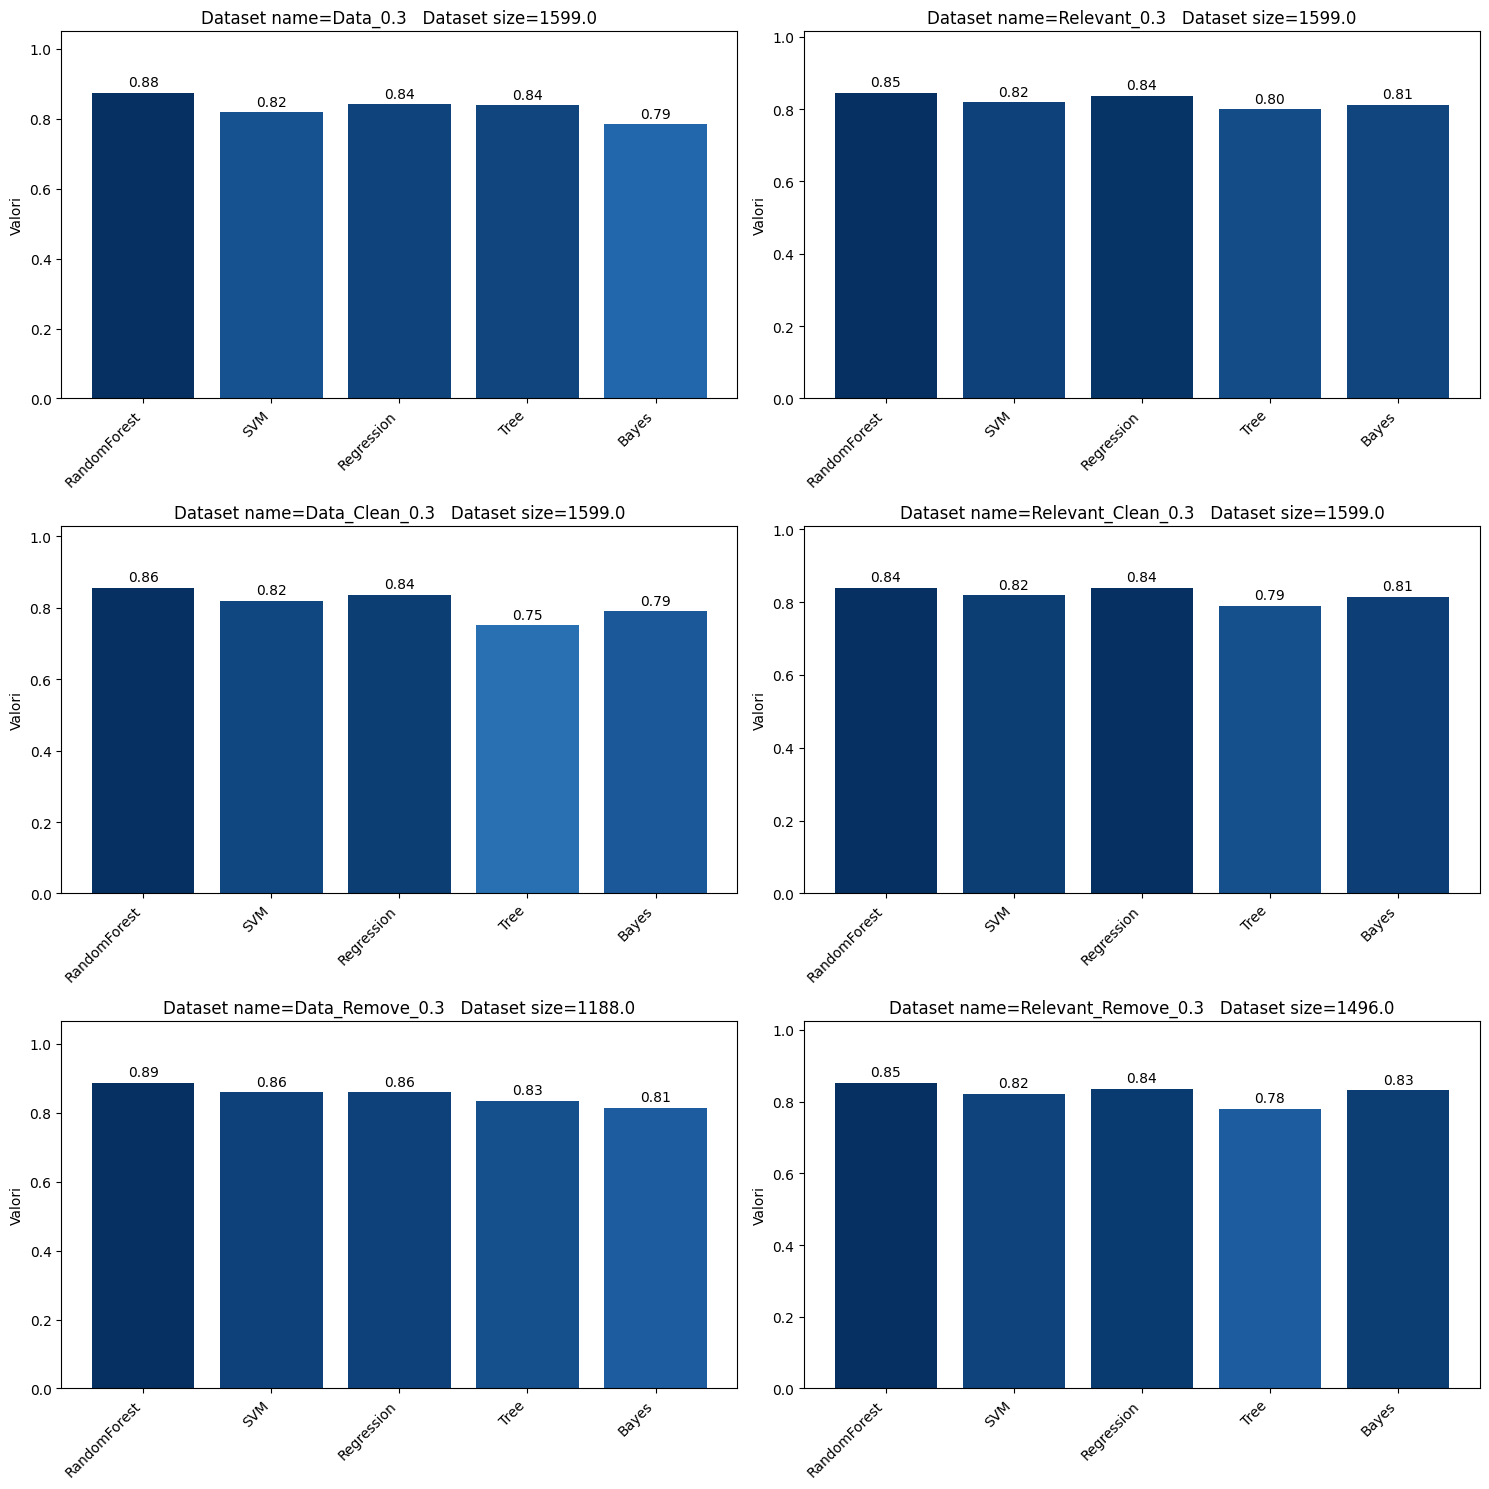

In [102]:
new_result['n_30']=classification_evo(new_data,0.30)
plot_result_evo(new_result['n_30'])

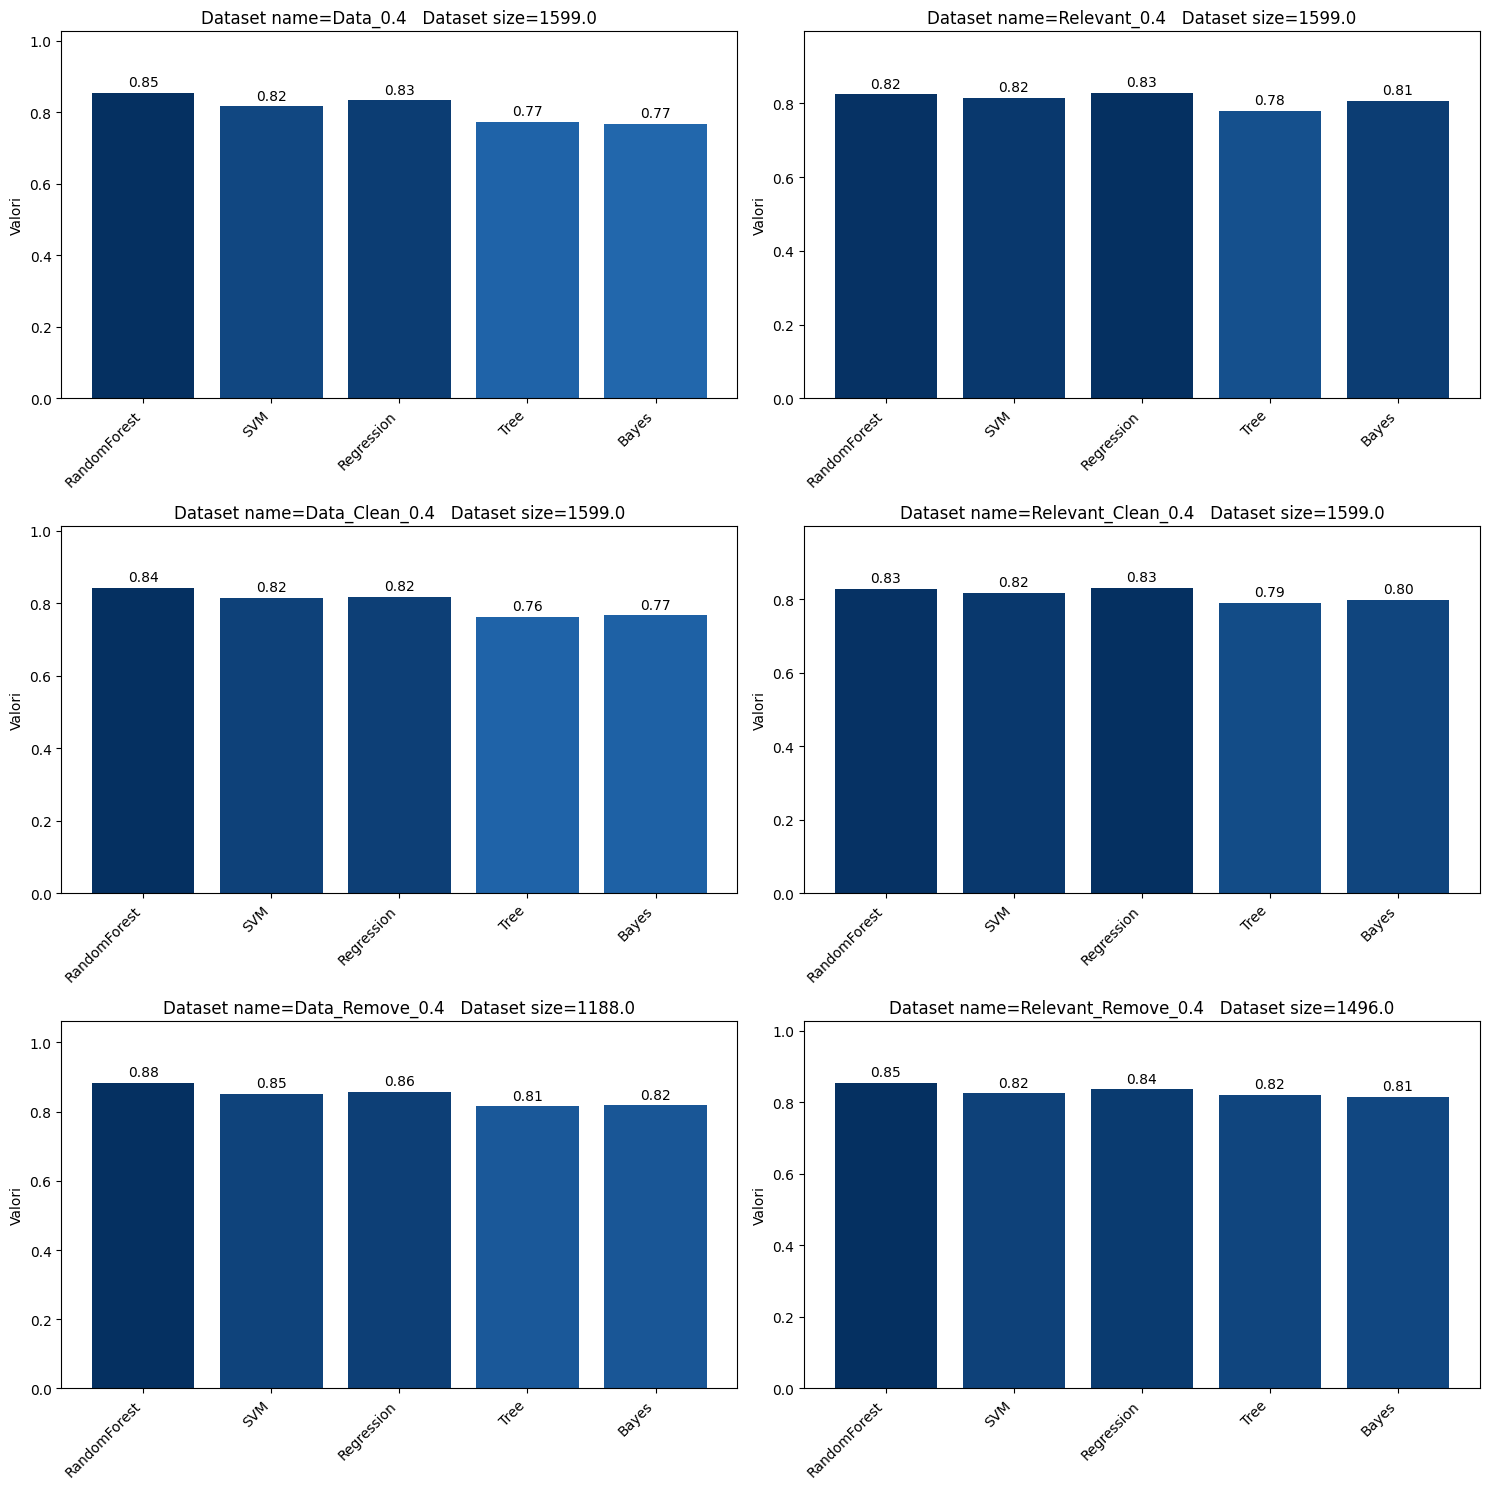

In [103]:
new_result['n_40']=classification_evo(new_data,0.40)
plot_result_evo(new_result['n_40'])

In [104]:
new_merged_df = pd.concat([new_result['n_10'],new_result['n_15'], new_result['n_20'],
                      new_result['n_25'], new_result['n_30'], new_result['n_40']],
                      axis=1)

In [105]:
new_merged_df

,Data_0.1,Relevant_0.1,Data_Clean_0.1,Relevant_Clean_0.1,Data_Remove_0.1,Relevant_Remove_0.1,Data_0.15,Relevant_0.15,Data_Clean_0.15,Relevant_Clean_0.15,...,Data_Clean_0.3,Relevant_Clean_0.3,Data_Remove_0.3,Relevant_Remove_0.3,Data_0.4,Relevant_0.4,Data_Clean_0.4,Relevant_Clean_0.4,Data_Remove_0.4,Relevant_Remove_0.4
Size,1599.00000,1599.000,1599.000,1599.000,1188.000000,1496.000,1599.000000,1599.000000,1599.0000,1599.000000,...,1599.000000,1599.000000,1188.000000,1496.000000,1599.000000,1599.000000,1599.00000,1599.00000,1188.000000,1496.000000
RandomForest,0.89400,0.887,0.875,0.869,0.866000,0.847,0.879000,0.896000,0.8630,0.883000,...,0.856000,0.840000,0.888000,0.853000,0.855000,0.825000,0.84400,0.82700,0.884000,0.855000
SVM,0.82500,0.825,0.825,0.825,0.832000,0.807,0.821000,0.821000,0.8210,0.821000,...,0.819000,0.819000,0.860000,0.822000,0.817000,0.816000,0.81600,0.81600,0.851000,0.825000
Regression,0.81875,0.825,0.825,0.825,0.823529,0.820,0.841667,0.845833,0.8375,0.841667,...,0.835417,0.839583,0.859944,0.835189,0.832812,0.829688,0.81875,0.83125,0.857143,0.836394
Tree,0.82500,0.775,0.787,0.800,0.815000,0.840,0.817000,0.787000,0.8000,0.817000,...,0.750000,0.790000,0.835000,0.780000,0.773000,0.780000,0.76400,0.78900,0.815000,0.821000
Bayes,0.79400,0.825,0.806,0.838,0.756000,0.813,0.804000,0.842000,0.8210,0.854000,...,0.790000,0.815000,0.815000,0.831000,0.767000,0.808000,0.76700,0.79700,0.819000,0.815000


In [106]:
new_d_1496 = new_merged_df.loc[:, (new_merged_df == 1599).any()]
new_df_1496=new_d_1496.drop(index=['Size'])
new_df_1496

,Data_0.1,Relevant_0.1,Data_Clean_0.1,Relevant_Clean_0.1,Data_0.15,Relevant_0.15,Data_Clean_0.15,Relevant_Clean_0.15,Data_0.2,Relevant_0.2,...,Data_Clean_0.25,Relevant_Clean_0.25,Data_0.3,Relevant_0.3,Data_Clean_0.3,Relevant_Clean_0.3,Data_0.4,Relevant_0.4,Data_Clean_0.4,Relevant_Clean_0.4
RandomForest,0.89400,0.887,0.875,0.869,0.879000,0.896000,0.8630,0.883000,0.859000,0.859000,...,0.850,0.8530,0.875000,0.8460,0.856000,0.840000,0.855000,0.825000,0.84400,0.82700
SVM,0.82500,0.825,0.825,0.825,0.821000,0.821000,0.8210,0.821000,0.809000,0.809000,...,0.810,0.8100,0.819000,0.8190,0.819000,0.819000,0.817000,0.816000,0.81600,0.81600
Regression,0.81875,0.825,0.825,0.825,0.841667,0.845833,0.8375,0.841667,0.834375,0.834375,...,0.830,0.8325,0.841667,0.8375,0.835417,0.839583,0.832812,0.829688,0.81875,0.83125
Tree,0.82500,0.775,0.787,0.800,0.817000,0.787000,0.8000,0.817000,0.794000,0.800000,...,0.797,0.7900,0.838000,0.8000,0.750000,0.790000,0.773000,0.780000,0.76400,0.78900
Bayes,0.79400,0.825,0.806,0.838,0.804000,0.842000,0.8210,0.854000,0.794000,0.828000,...,0.777,0.8180,0.785000,0.8120,0.790000,0.815000,0.767000,0.808000,0.76700,0.79700


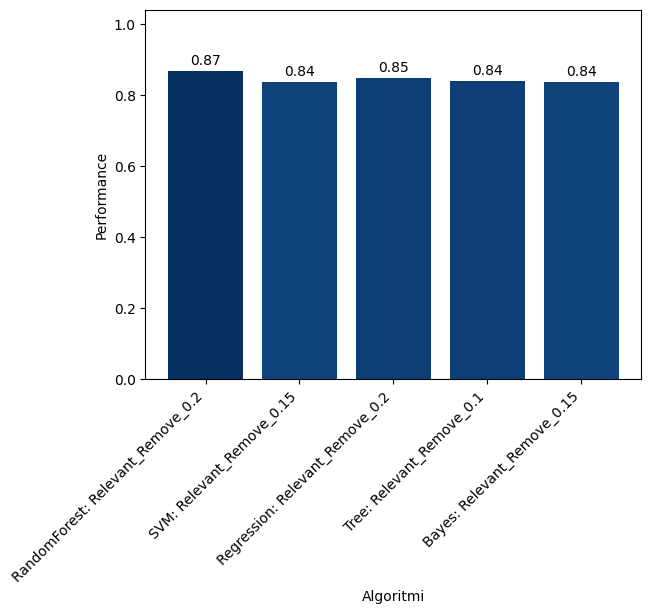

In [152]:
max_new_df_1599=trova_max(new_df_1496)
plot_bar_chart_df_evo(max_new_df_1599)

In [108]:
new_d_1496 = new_merged_df.loc[:, (new_merged_df == 1496).any()]
new_df_1496=new_d_1496.drop(index=['Size'])
new_df_1496

,Relevant_Remove_0.1,Relevant_Remove_0.15,Relevant_Remove_0.2,Relevant_Remove_0.25,Relevant_Remove_0.3,Relevant_Remove_0.4
RandomForest,0.847,0.862000,0.867000,0.856000,0.853000,0.855000
SVM,0.807,0.836000,0.833000,0.826000,0.822000,0.825000
Regression,0.820,0.844444,0.846667,0.839572,0.835189,0.836394
Tree,0.840,0.836000,0.840000,0.805000,0.780000,0.821000
Bayes,0.813,0.836000,0.827000,0.832000,0.831000,0.815000


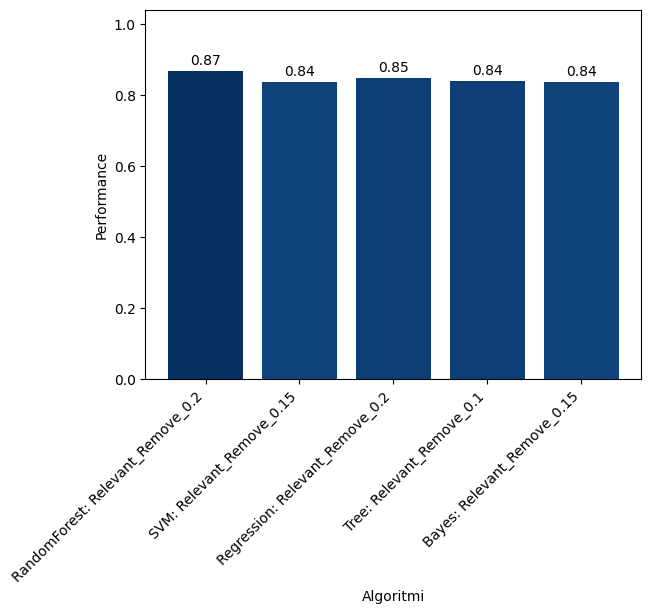

In [151]:
max_new_df_1496=trova_max(new_df_1496)
plot_bar_chart_df_evo(max_new_df_1496)

In [110]:
new_d_1188 = new_merged_df.loc[:, (new_merged_df == 1188).any()]
new_df_1188=new_d_1188.drop(index=['Size'])
new_df_1188

,Data_Remove_0.1,Data_Remove_0.15,Data_Remove_0.2,Data_Remove_0.25,Data_Remove_0.3,Data_Remove_0.4
RandomForest,0.866000,0.866000,0.861000,0.869000,0.888000,0.884000
SVM,0.832000,0.821000,0.836000,0.852000,0.860000,0.851000
Regression,0.823529,0.826816,0.840336,0.841751,0.859944,0.857143
Tree,0.815000,0.832000,0.815000,0.828000,0.835000,0.815000
Bayes,0.756000,0.782000,0.794000,0.801000,0.815000,0.819000


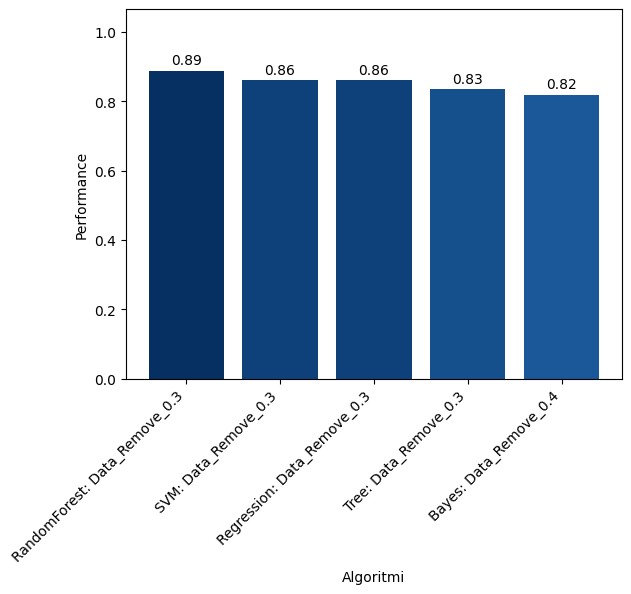

In [150]:
max_new_df_1188=trova_max(new_df_1188)
plot_bar_chart_df_evo(max_new_df_1188)